In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from fastai import *
from fastai.vision import *

### Constants, funcs and loads

In [3]:
bs = 64

In [4]:
path = Path('/home/ubuntu/Data/pneunonia/chest_xray/')

In [5]:
path.ls()

[PosixPath('/home/ubuntu/Data/pneunonia/chest_xray/train'),
 PosixPath('/home/ubuntu/Data/pneunonia/chest_xray/test'),
 PosixPath('/home/ubuntu/Data/pneunonia/chest_xray/.DS_Store')]

### Looking at the data

In [8]:
doc(ImageDataBunch.from_folder)

In [48]:
%%time
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(do_flip=False), size=224, bs=bs)
data.normalize(imagenet_stats)

CPU times: user 9.62 s, sys: 1.19 s, total: 10.8 s
Wall time: 5.47 s


In [49]:
data.valid_ds, data.train_ds

(DatasetTfm(ImageClassificationDataset of len 624),
 DatasetTfm(ImageClassificationDataset of len 5232))

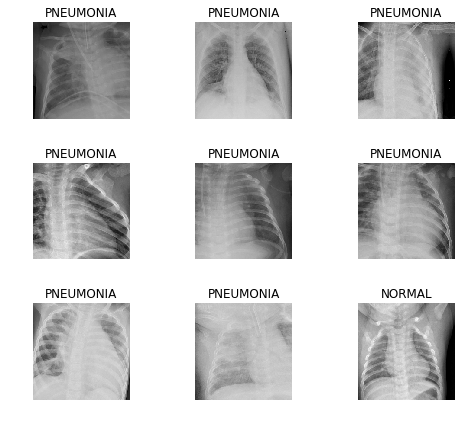

In [50]:
data.show_batch(rows=3, figsize=(7,6))

In [51]:
print(data.classes)

['NORMAL', 'PNEUMONIA']


###  Training

In [38]:
doc(metrics.fbeta)

In [25]:
doc(create_cnn)

In [52]:
learn = create_cnn(data=data, arch=models.resnet34, metrics=metrics.fbeta)

In [53]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


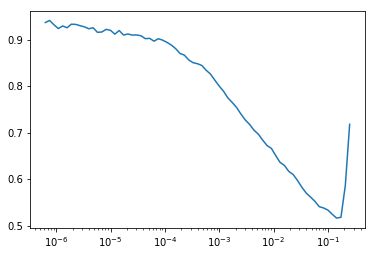

In [28]:
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(4, 0.003)

Total time: 06:25
epoch  train_loss  valid_loss  fbeta   
1      0.255008    0.557374    0.625534  (01:36)
2      0.146638    0.365023    0.634081  (01:35)
3      0.106672    0.329161    0.630342  (01:36)
4      0.077038    0.286477    0.628739  (01:36)



In [59]:
learn.save('stage-1')

### Interpriting results

In [56]:
interp = ClassificationInterpretation.from_learner(learn)

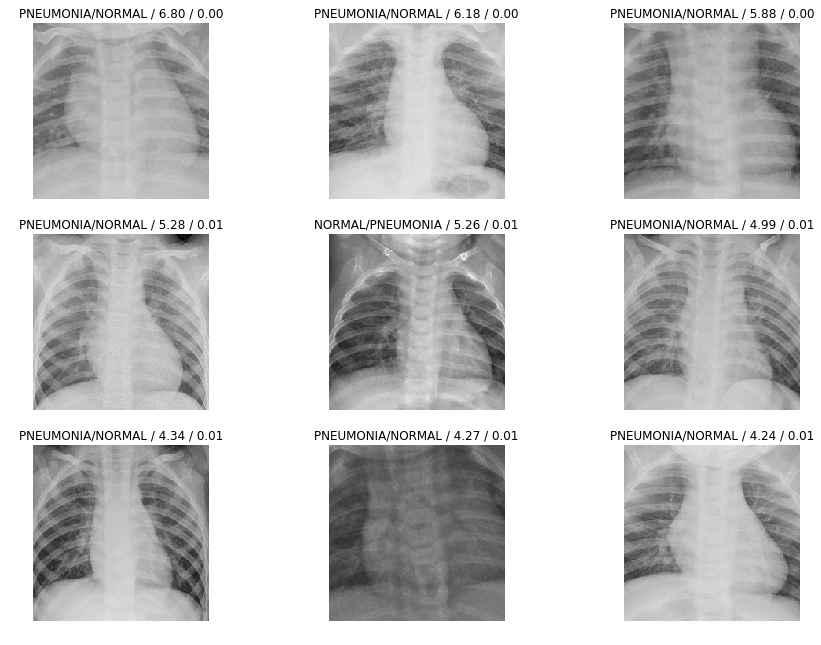

In [57]:
interp.plot_top_losses(9, figsize=(15,11))

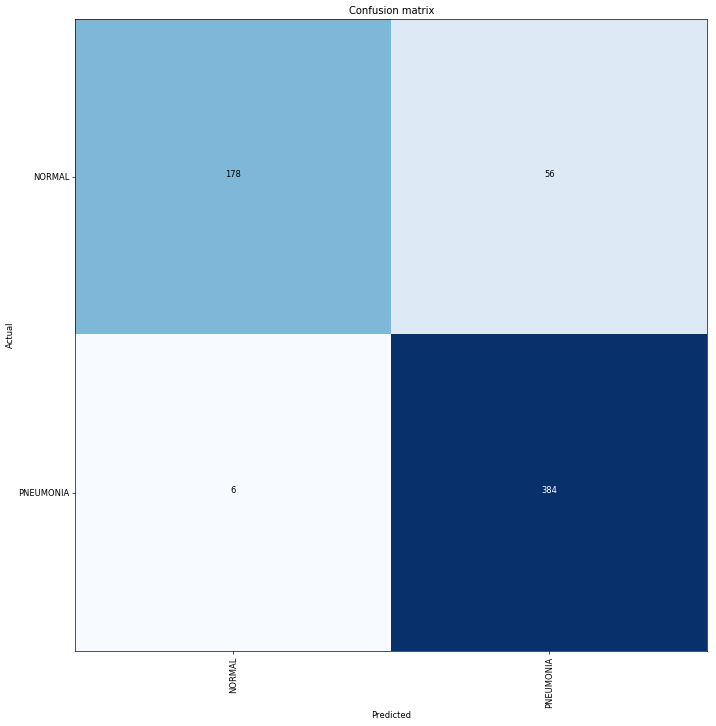

In [58]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Unfreezing, fine-tuning, and learning rates

In [60]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


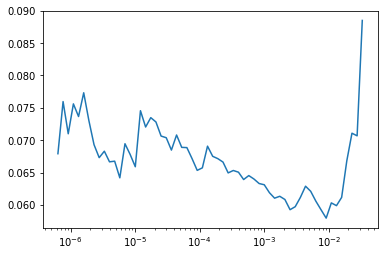

In [61]:
learn.recorder.plot()

In [62]:
learn.unfreeze()

In [63]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 03:19
epoch  train_loss  valid_loss  fbeta   
1      0.067589    0.269332    0.629274  (01:39)
2      0.057915    0.243537    0.627671  (01:39)



### Training: resnet50 

In [69]:
%%time
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(do_flip=False), size=320, bs=bs//2)
data.normalize(imagenet_stats)

CPU times: user 5.5 s, sys: 696 ms, total: 6.19 s
Wall time: 3.17 s


In [70]:
learn = create_cnn(data, models.resnet50, metrics=metrics.accuracy)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


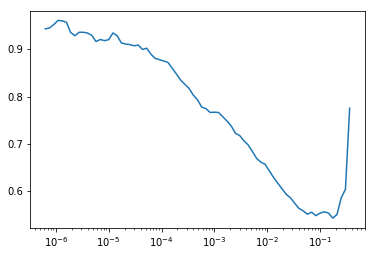

In [67]:
learn.lr_find()
learn.recorder.plot()

In [71]:
learn.fit_one_cycle(6, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,accuracy


RuntimeError: CUDA error: out of memory